# Exercício 06
## Teste de Hipótese
### Alunos:

 - Lucas Henrique Mantovani Jacintho - 10258942
 - Victor Luiz Fortes Rivelo - 9762960
 - Vinicius Henrique Borges - 9771546

---


## Objetivos da prática:
- Utilizar testes estatísticos para selecionar um modelo
- Utilizar ferramentas visuais para avaliar modelos


---

## Funções novas utilizadas no exercício

- `pandas.Series.nunique()` ([link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.nunique.html)): Conta quantidade de valores únicos de uma coluna. Útil para verificar se uma coluna é relevante ou não
- `scipy.stats.ttest_rel()` ([link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html)): Calcula o teste t para duas amostras
- `scipy.stats` ([link](https://docs.scipy.org/doc/scipy/reference/stats.html)) Implementações de alguns testes estatísticos
- `sklearn.metrics.plot_roc_curve()` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html)): Plota a curva ROC de um classificador dado um conjunto de input e alvo





---

Nesse exercício utilizaremos o dataset [Titanic](https://www.kaggle.com/c/titanic/overview) disponível no arquivo `titanic.csv`. Ele é um dataset de classificação binário, onde o objetivo é prever se um dado passageiro do titanic sobreviveu ou não ao naufrágio. Informações sobre os atributos podem ser vistas [aqui](https://www.kaggle.com/c/titanic/data)

---


### Questão 01.

Faça a exploração dos dados. Isto é, carregue, substitua valores faltantes, padronize os dados, etc. Faça também a seleção dos atributos que achar mais relevantes. 

 - Dica: Tente utilizar a função `nunique()` durante a exploração dos dados. Você também pode utilizar o "bom senso" (além de outras ferramentas é claro) na hora de escolher qual atributo do conjunto manter

In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv('/content/titanic.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [5]:
dataset.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
516,517,1,2,"Lemore, Mrs. (Amelia Milley)",female,34.0,0,0,C.A. 34260,10.5000,F33,S
84,85,1,2,"Ilett, Miss. Bertha",female,17.0,0,0,SO/C 14885,10.5000,NaN,S
511,512,0,3,"Webber, Mr. James",male,NaN,0,0,SOTON/OQ 3101316,8.0500,NaN,S
775,776,0,3,"Myhrman, Mr. Pehr Fabian Oliver Malkolm",male,18.0,0,0,347078,7.7500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [6]:
for column in dataset:
  print(column, dataset[column].nunique())

PassengerId 891
Survived 2
Pclass 3
Name 891
Sex 2
Age 88
SibSp 7
Parch 7
Ticket 681
Fare 248
Cabin 147
Embarked 3


In [7]:
dataset.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
dataset.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

Antes de aplicar téncnicas no conjunto de dados, podemos realizar algumas etapas de pré-processamento:
1. Precisaremos de alguma estratégia para completar as colubas _Age_, _Cabin_ e _Embarked_, pois apresentam valores faltantes.
2. As colunas _PassengerId_ e _Name_ podem ser removidas, pois apresentam valor único para cada exemplo e, portanto, não apresentam distinção em relação à classe. Também iremos remover a coluna Ticket, que representa apenas o número do ticket.
3. Podemos fazer over/undersampling, pois as classes estão ligeiramente desbalanceadas.
4. Seleção de variáveis utilizando a correlação. 
5. Transformar todos os atributos em numéricos utilizando o One-Hot encoding.
6. Podemos normalizar os dados, pois apresentam variação de escala.

#### Completar valores faltantes

In [9]:
not_na_dataset = dataset.copy()

Vamos avaliar quais são os valores únicos na coluna _Cabin_

In [10]:
dataset.Cabin.sort_values().unique()

array(['A10', 'A14', 'A16', 'A19', 'A20', 'A23', 'A24', 'A26', 'A31',
       'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'B101', 'B102', 'B18',
       'B19', 'B20', 'B22', 'B28', 'B3', 'B30', 'B35', 'B37', 'B38',
       'B39', 'B4', 'B41', 'B42', 'B49', 'B5', 'B50', 'B51 B53 B55',
       'B57 B59 B63 B66', 'B58 B60', 'B69', 'B71', 'B73', 'B77', 'B78',
       'B79', 'B80', 'B82 B84', 'B86', 'B94', 'B96 B98', 'C101', 'C103',
       'C104', 'C106', 'C110', 'C111', 'C118', 'C123', 'C124', 'C125',
       'C126', 'C128', 'C148', 'C2', 'C22 C26', 'C23 C25 C27', 'C30',
       'C32', 'C45', 'C46', 'C47', 'C49', 'C50', 'C52', 'C54', 'C62 C64',
       'C65', 'C68', 'C7', 'C70', 'C78', 'C82', 'C83', 'C85', 'C86',
       'C87', 'C90', 'C91', 'C92', 'C93', 'C95', 'C99', 'D', 'D10 D12',
       'D11', 'D15', 'D17', 'D19', 'D20', 'D21', 'D26', 'D28', 'D30',
       'D33', 'D35', 'D36', 'D37', 'D45', 'D46', 'D47', 'D48', 'D49',
       'D50', 'D56', 'D6', 'D7', 'D9', 'E10', 'E101', 'E12', 'E121',
       'E17',

Podemos observar que os valores são compostos de 1 letra e de 1 a 3 números. As letras vão de _A_ a _T_, o que sugere uma separação por categoria. Vamos transformar essa coluna mantendo apenas as letras e preencher os valores faltantes de forma aleatória, gerando os valores de acordo com a distribuição original.

In [11]:
cabin_categorical = dataset.Cabin.apply(lambda value: value[0] if type(value) == str else value)
cabin_categorical.value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

In [12]:
from random import choices

cabin_distribution = cabin_categorical.value_counts()
n_values = dataset.Cabin.isna().sum()

cabin_values = choices(cabin_distribution.index.tolist(), cabin_distribution.values.tolist(), k=n_values)

not_na_dataset.Cabin = cabin_categorical
not_na_dataset.loc[not_na_dataset.Cabin.isna(), 'Cabin'] = cabin_values

Para a coluna _Age_, vamos substituir o valor faltante pela média dos dados disponíveis.

In [13]:
not_na_dataset.Age.fillna(not_na_dataset.Age.mean(), inplace=True)

Para a coluna _Embarked_ vamos substituir os valores faltantes pela última observação válida

In [14]:
not_na_dataset.Embarked.fillna(method='bfill', inplace=True)

In [15]:
not_na_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Remover colunas PassengerId, Name e Ticket

In [16]:
dataset_without_columns = not_na_dataset.drop(columns=['PassengerId', 'Name', 'Ticket'])

#### Oversampling

In [17]:
class_0 = dataset_without_columns[dataset_without_columns.Survived == 0]
class_1 = dataset_without_columns[dataset_without_columns.Survived == 1]
n_samples = class_0.shape[0]

class_1_samples = class_1.sample(n_samples, replace=True)

oversampled_dataset = pd.concat((class_0, class_1_samples))

In [18]:
oversampled_dataset.Survived.value_counts()

1    549
0    549
Name: Survived, dtype: int64

#### Avaliando correlação de variáveis

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


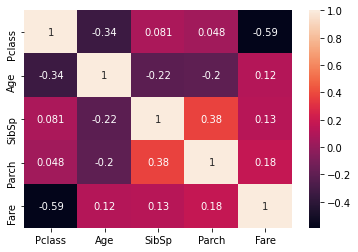

In [19]:
import seaborn as sns

corr = oversampled_dataset.drop(columns='Survived').corr()
sns.heatmap(corr, annot=True);

Pelo gráfico, podemos ver que não existem variáveis com correlação alta, portanto, iremos manter todas as variáveis.

#### Transformação para valores numéricos

In [20]:
numeric_dataset = pd.get_dummies(oversampled_dataset)

#### Normalização

Vamos primeiro separar os dados em exemplos e rótulo

In [21]:
X = numeric_dataset.iloc[:, 1:]
y = numeric_dataset.iloc[:, 0]

In [22]:
from sklearn.preprocessing import scale

scaled_X = scale(X.select_dtypes(exclude='object'))
scaled_X

array([[ 0.83624665, -0.505018  ,  0.50943237, ..., -0.5204165 ,
        -0.32174149,  0.66546102],
       [ 0.83624665,  0.45666986, -0.48057956, ..., -0.5204165 ,
        -0.32174149,  0.66546102],
       [ 0.83624665,  0.06453184, -0.48057956, ..., -0.5204165 ,
         3.10808529, -1.50271762],
       ...,
       [-1.52113158,  0.75257381,  0.50943237, ...,  1.92153785,
        -0.32174149, -1.50271762],
       [-0.34244247,  0.08678991, -0.48057956, ..., -0.5204165 ,
         3.10808529, -1.50271762],
       [ 0.83624665,  0.67859782,  0.50943237, ..., -0.5204165 ,
        -0.32174149,  0.66546102]])



---

### Questão 02.

Utilize o 10-fold cross-validation para calcular a acurácia dos classificadores abaixo. Armazene a acurácia calculada em cada fold na variavel `scores` para cada um dos modelos.


In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

classificadores = {
  "Perceptron" : {"modelo": Perceptron(), "scores": []},
  "Multi-Layer Perceptron (15,)" : {"modelo": MLPClassifier(random_state=1, hidden_layer_sizes=(15,), max_iter=2000), "scores": []},
  "SVM Polinomial Grau 3" : {"modelo": SVC(kernel='poly', degree=3, gamma='scale'), "scores": []},
  "Árvore Decisão Critério Gini" : {"modelo": DecisionTreeClassifier(criterion='gini'), "scores": []},  
  "KNN k=5" : {"modelo": KNeighborsClassifier(n_neighbors=5), "scores": []}
}

In [24]:
from sklearn.model_selection import cross_validate

for classifier, classifier_dict in classificadores.items():
  result = cross_validate(classifier_dict['modelo'], scaled_X, y, cv=10)
  classifier_dict['scores'] = result['test_score']

  print(f'{classifier}: {classifier_dict["scores"]}')

Perceptron: [0.63636364 0.73636364 0.69090909 0.78181818 0.72727273 0.56363636
 0.6        0.79090909 0.81651376 0.68807339]
Multi-Layer Perceptron (15,): [0.82727273 0.81818182 0.8        0.80909091 0.83636364 0.74545455
 0.80909091 0.82727273 0.82568807 0.89908257]
SVM Polinomial Grau 3: [0.76363636 0.79090909 0.73636364 0.79090909 0.77272727 0.74545455
 0.79090909 0.80909091 0.81651376 0.86238532]
Árvore Decisão Critério Gini: [0.84545455 0.88181818 0.85454545 0.84545455 0.89090909 0.84545455
 0.9        0.85454545 0.89908257 0.86238532]
KNN k=5: [0.8        0.8        0.73636364 0.79090909 0.8        0.73636364
 0.83636364 0.79090909 0.79816514 0.85321101]




---

### Questão 03.

Selecione os dois melhores classificadores e verifique se há diferença estatística significante entre suas acurácias utilizando o teste T (`scipy.stats.ttest_rel`). Você pode utilizar outro tipo de teste, desde que faça a justificativa. Considere que há diferença significante se p <= 0.05 (rejeita-se a hipótese nula)

- Nesse [link](https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/) o autor discute alguns pontos interessantes para se escolher um teste estatístico
- No [link](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/) é feito um sumário dos testes implementados no scipy

In [25]:
for classifier, classifier_dict in classificadores.items():
  print(f'{classifier}: {classifier_dict["scores"].mean()}')

Perceptron: 0.703185988323603
Multi-Layer Perceptron (15,): 0.8197497914929107
SVM Polinomial Grau 3: 0.7878899082568808
Árvore Decisão Critério Gini: 0.8679649708090075
KNN k=5: 0.7942285237698081


In [26]:
from scipy.stats import ttest_rel

ttest_rel(classificadores['Multi-Layer Perceptron (15,)']['scores'], classificadores['Árvore Decisão Critério Gini']['scores'])

Ttest_relResult(statistic=-3.845601168163378, pvalue=0.003932681992240779)

Como p ~= 0.004 < 0.05, podemos concluir que **existe** uma diferença significante entre os dois modelos - Multi-Layer Perceptron (15 neurônios) e Árvore de Decisão com Critério Gini.



---

### Questão 04.

Separe o conjunto de dados de maneira estratificada (através do parâmetro `stratify` da função `train_test_split`) em 20% para teste e 80% para treino. Depois plote a curva ROC (`sklearn.metrics.plot_roc_curve`) para **todos** os classificadores (no mesmo gráfico). 

Os melhores classificadores da questão anterior também apresentaram melhor desempenho na curva ROC? O que pode ter ocorrido? Teste diferentes valores de `random_state` na função `train_test_split` e observe o comportamento das curvas.


*   Dica: Para plotar múltiplas curvas ROC no mesmo gráfico, defina uma figura com `fig, ax = plt.subplots()` e passe `ax` como parâmetro da função `plot_roc_curve`. Não se esqueça de passar também o nome do classificador para que o seu gráfico fique mais fácil de interpretar



In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

In [28]:
def roc_curve(random_state):
  fig, ax = plt.subplots(figsize=(10,10))
  
  X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=random_state)

  for classifier_name, classifier_dict in classificadores.items():
    model = classifier_dict['modelo']
    model.fit(X_train, y_train)
    plot_roc_curve(model, X_test, y_test, name=classifier_name, ax=ax)
  
  plt.show()

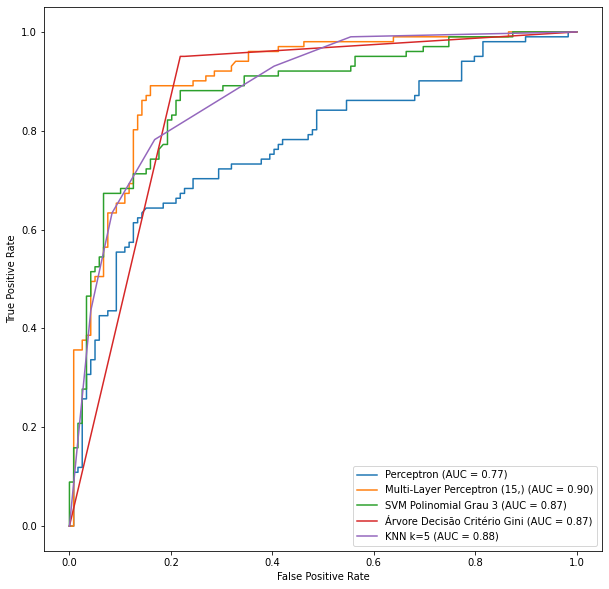

In [29]:
roc_curve(random_state=42)

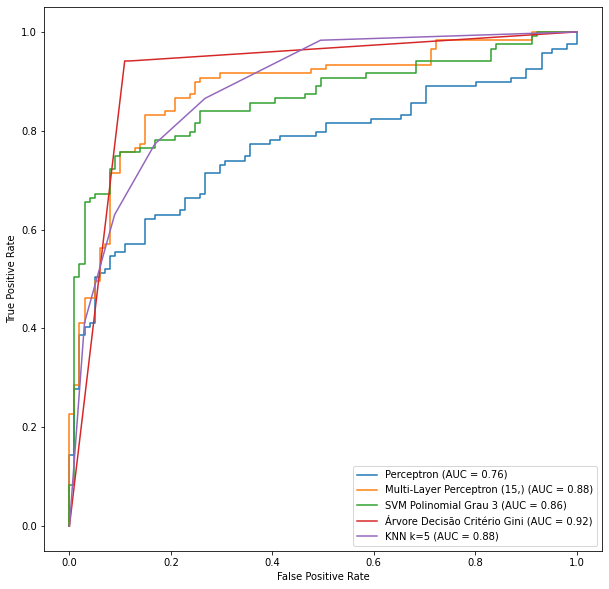

In [30]:
roc_curve(random_state=12)

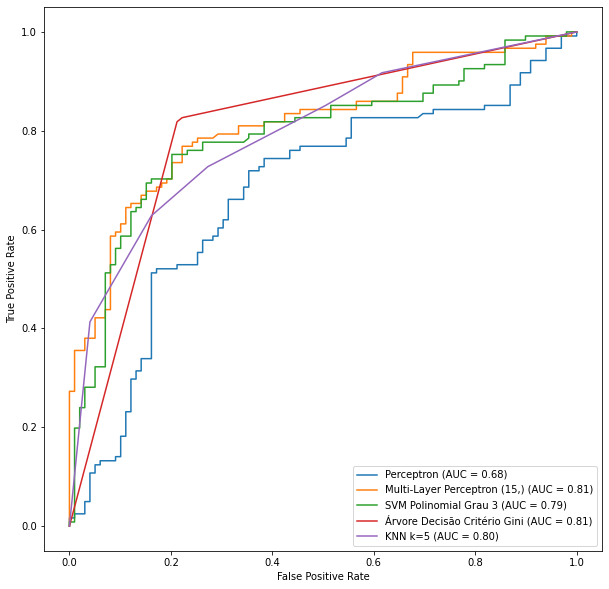

In [31]:
roc_curve(random_state=2)

No geral, o valor AUC da Árvore de Decisão e do MLP apresentaram os melhores resultados entre todos os classificadores avaliados. Esse comportamento condiz com os desempenhos calculados na questão 3 (média das acurácias). Porém, vale ressaltar que curva ROC e acurácia são métodos de avaliação distintos e não há garantias de serem condizentes: um classificador de alta acurácia poderia produzir um valor alto de TFP, o que não é ideal caso se deseje minimizar a quantidade de alarmes falsos.

Adicionalmente, uma característica interessante da curva ROC da Árvore de Decisão é que este classificador, em geral, contém o ponto mais próximo ao canto superior esquerdo do gráfico - coordenada (1, 0) - o que nos mostra que ele possui o melhor desempenho ponderado entre TVP e TFP dentre todos os modelos. Ou seja, em um cenário onde a taxa de verdadeiros positivos é tão importante quanto a taxa de falsos positivos, a Árvore de Decisão deverá ser o modelo adotado.



---

### Questão 05.

Agora utilize a função `plot_roc` definida abaixo para o modelo com maior e menor acurácia (de acordo como você calculou na questão 02). Essa função irá calcular a curva ROC utilizando 10-fold cross-validation, exibindo a curva média bem como as curvas para cada fold. Comente se agora o resultado foi conforme o esperado.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

def plot_roc(classifier, X, y):
  cv = StratifiedKFold(n_splits=10)  

  if isinstance(X, pd.core.frame.DataFrame):
    X = X.values
  if isinstance(y, pd.core.frame.DataFrame) or isinstance(y, pd.core.series.Series):
    y = y.values

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(X, y)):
      classifier.fit(X[train], y[train])
      viz = plot_roc_curve(classifier, X[test], y[test],
                          name='ROC fold {}'.format(i),
                          alpha=0.3, lw=1, ax=ax)
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)  

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example")
  ax.legend(loc="lower right")
  plt.show()

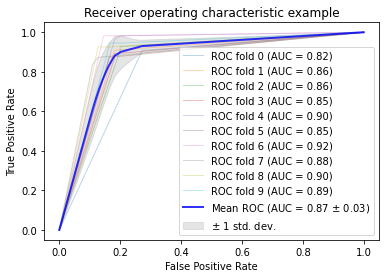

In [33]:
plot_roc(classificadores['Árvore Decisão Critério Gini']['modelo'], scaled_X, y)

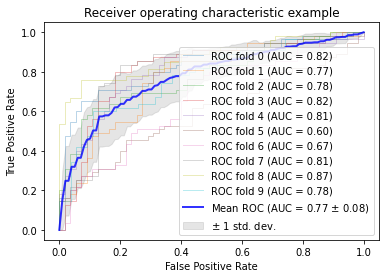

In [34]:
plot_roc(classificadores['Perceptron']['modelo'], scaled_X, y)

O valor médio de AUC da Árvore de Decisão (0.87) é consideravelmente maior do que o do Perceptron (0.77). Com base unicamente nos resultados de acurácia média (questão 3) e da curva ROC (questão 4) desses modelos, podemos dizer que esses valores estão dentro do esperado.



---

### Questão bônus:

Para essa questão você deve testar o seu algoritmo em um conjunto de dados nunca visto através do site [Kaggle](https://www.kaggle.com/c/titanic/overview). A ideia é prever as classes dos dados do arquivo `questao_extra.csv` e submeter o resultado no Kaggle, para que o mesmo faça a avaliação.

O arquivo que você deverá submeter no site deverá conter apenas a coluna "PassegerID" e "Survived" (há um arquivo de submissão de exemplo na pasta do exercício). Na figura abaixo podemos ver a distribuição de performance dos participantes dessa competição.

Note que nessa questão você deve treinar o seu classificador com todos os dados disponíveis (ou seja, todos os dados do arquivo `titanic.csv`).

**Reporte o seu resultado aqui para eu saber o quão bem vocês foram!**

*   Dica: Você pode gerar um arquivo csv a partir de um `DataFrame` com a função `pandas.DataFrame.to_csv`. Lembre-se de passar `index=False`

![alt text](http://playagricola.com/Kaggle/first.png)





